# Building SFINCS inputs from the v20.1 Hydrofabric

### Step 0: Import packages and read input data

In [13]:
from pathlib import Path

import os
import networkx as nx
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
from shapely.geometry import box
import matplotlib.pyplot as plt
import contextily as cx
import zarr

import hydromt
from hydromt_sfincs import SfincsModel
from hydromt_sfincs import utils

In [14]:
import networkx as nx
gpkg = "/Users/taddbindas/hydrofabric/v20.1/gpkg/nextgen_11.gpkg"
flowlines = gpd.read_file(gpkg, layer="flowpaths")
nexus = gpd.read_file(gpkg, layer="nexus")
divides = gpd.read_file(gpkg, layer="divides")
flowpath_attributes = gpd.read_file(gpkg, layer="flowpath_attributes")

In [15]:
root_path = Path("/Users/taddbindas/projects/hydromt_sfincs/examples/tmp_flooding_data")
G = nx.DiGraph()
nexus_to_toid = dict(zip(nexus['id'], nexus['toid']))
for _, node in nexus.iterrows():
    G.add_node(node['id'], 
               type=node['type'], 
               geometry=node['geometry'],
               toid=node['toid'])

for _, edge in flowlines.iterrows():
    G.add_edge(edge['id'], edge['toid'], 
               mainstem=edge['mainstem'],
               order=edge['order'],
               hydroseq=edge['hydroseq'],
               lengthkm=edge['lengthkm'],
               areasqkm=edge['areasqkm'],
               tot_drainage_areasqkm=edge['tot_drainage_areasqkm'],
               has_divide=edge['has_divide'],
               divide_id=edge['divide_id'],
               geometry=edge['geometry'])
    
    if edge['toid'] in nexus_to_toid:
        G.add_edge(edge['toid'], nexus_to_toid[edge['toid']])

# Print some basic information about the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Example of accessing node attributes
print("\nExample node attributes:")
example_node = list(G.nodes())[0]
print(f"Attributes of node {example_node}:")
print(G.nodes[example_node])

# Example of accessing edge
print("\nExample edge:")
example_edge = list(G.edges())[0]
print(f"Edge: {example_edge}")

Number of nodes: 92211
Number of edges: 92156

Example node attributes:
Attributes of node nex-1000006131:
{'type': 'nexus', 'geometry': <POINT (-411313.625 1707430.743)>, 'toid': 'wb-1000006131'}

Example edge:
Edge: ('nex-1000006131', 'wb-1000006131')


In [16]:
start_node = "nex-2177032"
end_node = "nex-2175887"
path = nx.shortest_path(G, start_node, end_node)

In [17]:
mask_flowlines = flowlines["id"].isin(path)
mask_nexus = nexus["id"].isin(path)
mask_divides = divides["id"].isin(path)
mask_attributes = flowpath_attributes["id"].isin(path)

_subset_nexus = nexus[mask_nexus]
_subset_flowlines = flowlines[mask_flowlines]
_subset_divides = divides[mask_divides]
_subset_attributes = flowpath_attributes[mask_attributes]

### Step 1: Set up model

In [18]:
root = Path("/Users/taddbindas/projects/hydromt_sfincs/examples/tmp_ngwpc_data/")
yml_str = f"""
meta:
  root: {root.__str__()}
  
10m_lidar:
  path: HUC6_110701_dem.tiff
  data_type: RasterDataset
  driver: raster
  driver_kwargs:
    chunks:
      x: 6000
      y: 6000
  meta:
    category: topography
    crs: 5070
  rename:
    10m_lidar: elevtn
"""
data_lib = "tmp_data_catalogs/10m_huc6_lidar.yml"
with open(data_lib, mode="w") as f:
    f.write(yml_str)

In [19]:
# Initialize SfincsModel Python class with the artifact data catalog which contains publically available data for North Italy
# we overwrite (mode='w+') the existing model in the root directory if it exists
data_catalog = hydromt.DataCatalog(data_libs=[data_lib])
sf = SfincsModel(data_libs=["tmp_data_catalogs/10m_huc6_lidar.yml"], root="tmp_ngwpc_data", mode="w+")

### Step 2: Set up Grid

- This is the bounding box around the catchments of interest

In [20]:
sf.setup_grid_from_region(
    region = {'geom': 'tmp_ngwpc_data/coffeyville/flowlines_divides.geojson'},
    res= 50,
    rotated=True,
    crs=_subset_divides.crs  # NAD83 / Conus Albers HARDCODED TODO figure out making this cleaner
)
# the input file is automatically updated. Uncomment to displayed below:
print(sf.config)

{'mmax': 199, 'nmax': 499, 'dx': 50, 'dy': 50, 'x0': 32932.0, 'y0': 1533316.0, 'rotation': 5.758, 'latitude': 0.0, 'tref': datetime.datetime(2010, 2, 1, 0, 0), 'tstart': datetime.datetime(2010, 2, 1, 0, 0), 'tstop': datetime.datetime(2010, 2, 2, 0, 0), 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 0, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015], 'epsg': 5070}


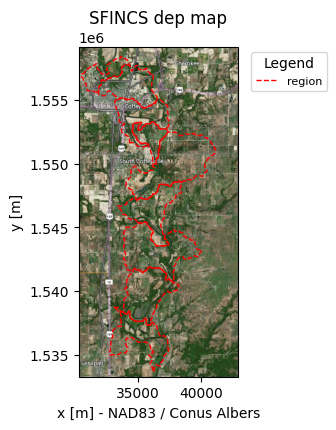

In [21]:
# show the model grid outline
# sf.region.boundary.plot(figsize=(6,6))
_ = sf.plot_basemap(plot_region=True, bmap="sat", zoomlevel=12)

### Step 3: Load in Elevation Data

In [22]:
datasets_dep = [{"elevtn": "10m_lidar", "zmin": 0.001}]

# Add depth information to modelgrid based on these chosen datasets
sf.setup_dep(datasets_dep=datasets_dep)

# # Make a plot of the merged topobathy, here colour limits are set between an elevation of -5 to 5 meters
# _ = sf.plot_basemap(variable="dep", bmap="sat", zoomlevel=12)

### Step 4: Mask active cells

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


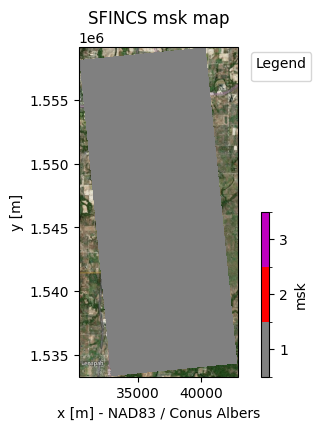

In [23]:
# Choosing how to choose you active cells can be based on multiple criteria, here we only specify a minimum elevation of -5 meters
sf.setup_mask_active(zmin=-5, reset_mask=True)

# Make a plot of the mask file
_ = sf.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)

### Step 5: Add output boundaries

<GeoAxes: title={'center': 'SFINCS msk map'}, xlabel='x [m] - NAD83 / Conus Albers', ylabel='y [m]'>

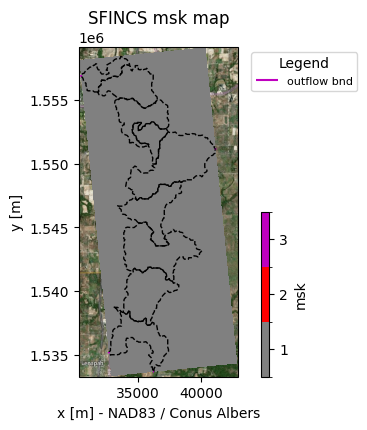

In [24]:
# file_name = "data//compound_example_outflow_boundary_polygon.geojson"
gdf_include = sf.data_catalog.get_geodataframe("tmp_ngwpc_data/coffeyville/flowlines_divides.geojson")

# Here we add water level cells along the coastal boundary, for cells up to an elevation of -5 meters
sf.setup_mask_bounds(btype="waterlevel", zmax=-5, reset_bounds=True)

# Here we add outflow cells, only where clicked in shapefile along part of the lateral boundaries
sf.setup_mask_bounds(btype="outflow", include_mask=gdf_include, reset_bounds=True)

# Make a plot of the mask file
fig, ax = sf.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)
gdf_include.to_crs(sf.crs).boundary.plot(
    ax=ax, color="k", lw=1, ls="--"
)  # plot the shapefile given by the user as dashed line

### Step 6: Add river inflow data

{'mmax': 199, 'nmax': 499, 'dx': 50, 'dy': 50, 'x0': 32932.0, 'y0': 1533316.0, 'rotation': 5.758, 'latitude': 0.0, 'tref': datetime.datetime(2010, 2, 1, 0, 0), 'tstart': datetime.datetime(2010, 2, 1, 0, 0), 'tstop': datetime.datetime(2010, 2, 2, 0, 0), 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 0, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015], 'epsg': 5070, 'depfile': 'sfincs.dep', 'mskfile': 'sfincs.msk', 'indexfile': 'sfincs.ind'}


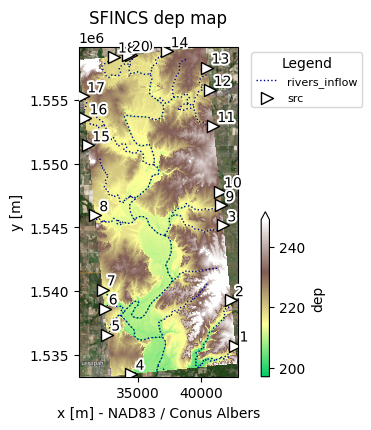

In [25]:
sf.setup_river_inflow(
    rivers=flowlines, keep_rivers_geom=True
)
print(sf.config)
# Make a plot of model
# note the src points and derived river network
fig, ax = sf.plot_basemap(variable="dep", plot_bounds=False, bmap="sat", zoomlevel=12)

In [26]:
# --> this is used when the making subgrid tables (step 8)

# use the derived rivers to burn these into the model subgrid
# note that the width and depth are arbitrary here

gdf_riv = sf.geoms["rivers_inflow"].copy()
ordered_ids = gdf_riv["id"]

df_reordered = pd.merge(ordered_ids, _subset_attributes, on='id', how='left')
df_reordered["n"].dropna()
# gdf_riv["rivwth"] = [100, 50, 50]  # width [m]
# gdf_riv["rivdph"] = 1.5  # depth [m]
# gdf_riv["manning"] = 0.03  # manning coefficient [s.m-1/3]
# gdf_riv[["geometry", "rivwth", "rivdph", "manning"]]

# prepare the river dataset for the subgrid
# instead of using the derived rivers, you could also use an aribitrary shapefile with centerlines
# Other options include to add a river mask shapefile rather than a river width attribute
# Note that the width is either specified on the river centerline or with a river mask
# Also the river bed level (rivbed) can be specified instead of the river depth (rivdph).

# datasets_riv = [{"centerlines": gdf_riv}]



6     0.05000
8     0.05000
11    0.05000
17    0.05000
22    0.05000
24    0.05747
31    0.05000
35    0.05317
36    0.05414
Name: n, dtype: float64

### 7. Add spatially varying roughness data:

Not ready yet

### 8. Make subgrid derived tables:
Subgrid derived tables are used to better capture the elevation and roughness of your domain, to either improve your results, or to allow you to run on a courser grid resolution (means faster simulation). For more info about subgrid tables, [click here](https://sfincs.readthedocs.io/en/latest/developments.html#recent-advancements-in-accuracy-subgrid-mode). 

You as user can specify multiple settings about how the subgrid derived tables should be made.

Every single grid cell of the flux grid of the size inp.dx by inp.dy is defined into subgrid pixels (default nr_subgrid_pixels = 20).
For every subgrid pixel the topobathy data is loaded, ideally this consists of high-resolution DEM datasets that you specify as user.

In this example with dx=dy=50m, having nr_subgrid_pixels = 20 means we are loading data onto a 2.5 m subpixel grid
However, the input data of Gebco and Merit_hydro is way coarser, therefore let's set the ratio to 5 for now.

In [27]:
sf.setup_subgrid(
    datasets_dep=datasets_dep,
    datasets_riv=datasets_riv,
    nr_subgrid_pixels=5,
    write_dep_tif=True,
    write_man_tif=False,
)

NameError: name 'datasets_riv' is not defined

### 9. Add spatially varying infiltration data:

Not ready yet

### 10. Add water level time-series as forcing:

### 11. Add an upstream discharge time-series as forcing (NWM retrospective)

**a. specify discharge input locations: srcfile**

For more info about what the srcfile is, [click here](https://sfincs.readthedocs.io/en/latest/input_forcing.html#discharge-points)

**b. specify discharge time-series: disfile**

For more info about what the disfile is, [click here](https://sfincs.readthedocs.io/en/latest/input_forcing.html#discharge-time-series)

### 12. Add spatially varying rainfall data:

Not ready yet

### 13. Add weirfile:
In SFINCS, a weirfile is often used to explicity account for line-element features such as dikes, dunes or floodwalls. Read more about structures in the [SFINCS manual](https://sfincs.readthedocs.io/en/latest/input_structures.html)

### 14. Add observation points:

For more info about what the obsfile is, [click here](https://sfincs.readthedocs.io/en/latest/input.html#observation-points)

### 14. Add observation lines:

Observation lines (cross-sections) can be added to monitor discharges through cross-sections. For more info about what the crsfile is, [click here](https://sfincs.readthedocs.io/en/latest/input.html#cross-sections-for-discharge-output)

### 15. Show model:

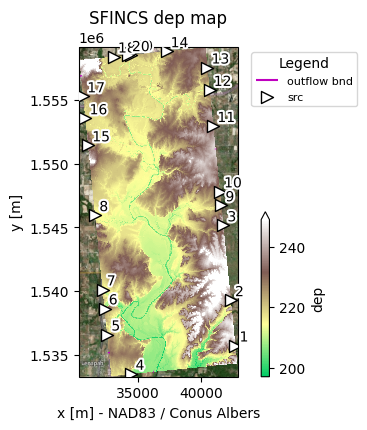

In [286]:
# Use predefined plotting function 'plot_basemap' to show your full SFINCS model setup
_ = sf.plot_basemap(fn_out="basemap.png", bmap="sat", zoomlevel=12)

### 16. Save all files

In [287]:
sf.write()  # write all
dir_list = os.listdir(sf.root)
print(dir_list)

['sfincs.dis', 'sfincs.dep', 'sfincs.msk', 'coffeyville', '.DS_Store', 'Central_US_Spring_2019.gpkg', 'hydromt.log', 'figs', 'boundaries.geojson', 'sfincs.src', 'upstream_location.gpkg', 'output_11070103.geojson', 'formatted-json-data.json', 'huc8s_sp.gpkg', 'build_hydrofabric.py', '2930769_subset.gpkg', 'hydromt_data.yml', 'HUC6_110701_dem.tiff', 'output_bbox_11070103.geojson', 'downstream_location.gpkg', 'sfincs.ind', 'nws_lid.gpkg', 'sfincs.inp', '01070006-nchn3-usgs.json', 'gis']
